## Code for plotting Figure 4, Supplementary Figure 1, and Supplementary Figure 2
### Written by Vinsea A V Singh on 

### Original paper:
#### 'Characterizing Variability of Audiovisual Speech Perception Based on Periodic and Aperiodic Features of Pre-stimulus Brain Activity'
#### Paper link - https://www.biorxiv.org/content/10.1101/2022.01.20.477172v1

### Import libraries

In [1]:
## Python version 3.9.7
## Scipy version 
## matplotlib version 

import sys
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

# Import mne toolbox
!pip install mne
import mne
from mne import io
from mne.viz import *
from mne.stats import permutation_cluster_test, permutation_t_test

# For permutation testing
!pip install mlxtend 
from mlxtend.evaluate import permutation_test

# Import the FOOOF object
!pip install fooof
from fooof import FOOOF
from fooof import FOOOFGroup

## After applying FOOOF
# Import utilities to manage frequency band definitions
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum, plot_spectra

# Import plotting function for model parameters and components
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits

In [2]:
#EEG sensors montage using standard_1020
def eeg_sensor_pos(EEG):
    #extract the info
    EEG_info = EEG.info
    
    picks = mne.pick_channels(EEG.info['ch_names'], include=[], exclude=['VEO', 'HEO', 'EKG', 'EMG'])
    mne.pick_info(EEG.info, picks, copy=False)
    
    # Clean and replace channel names to be able to use a standard 1005 montage
    new_names = dict(
        (ch_names,
         ch_names.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp').
        replace('CB1','PO9').replace('CB2','PO10'))
        for ch_names in EEG.ch_names)
    EEG.rename_channels(new_names)
    
    # Form the 10-20 montage
    mont1020 = mne.channels.make_standard_montage('standard_1020')

    # Choose what channels you want to keep (64 channels)
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ['Fp1','Fpz','Fp2','AF3','AF4','F7','F5','F3','F1','Fz','F2',
                     'F4', 'F6','F8','FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6',
                     'FT8','T7','C5','C3','C1','Cz','C2','C4','C6','T8','M1','TP7',
                     'CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8','M2','P7','P5',
                     'P3', 'P1','Pz','P2','P4','P6','P8','PO7','PO5','PO3','POz','PO4',
                     'PO6','PO8','PO9','O1','Oz','O2','PO10']

    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()

    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]

    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    mont1020.plot()
    mont1020_new.plot()
    
    EEG.set_montage(mont1020_new,on_missing='warn')
    
    return(EEG, kept_channels)

Reading 0 ... 429879  =      0.000 ...   429.879 secs...
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


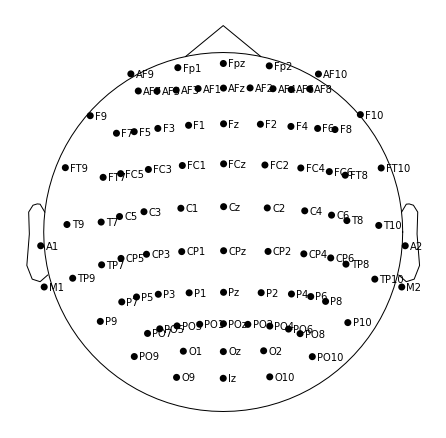

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


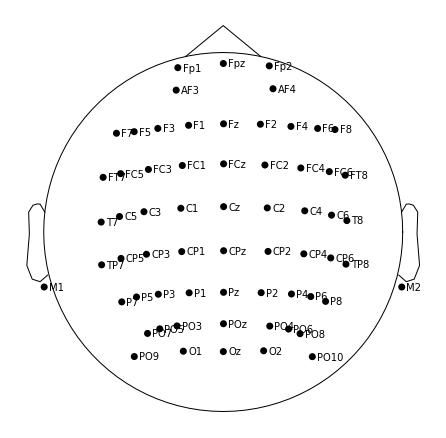

In [3]:
#### EEG sensors montage using standard_1020
# Import raw EEG .cnt file
EEG =  mne.io.read_raw_cnt('C:/Users/dipanjanroy/Desktop/Project/Manuscript_codes/McG_110_1.cnt', preload=True)

EEG_montage, channels = eeg_sensor_pos(EEG)
#EEG_montage.plot_sensors()

In [4]:
# Function to perform the fooof analysis groupwise for plotting the line plots
def fooof_analysis(freqs, psds, freq_range, ttype):
    if ttype == 1:
        fm = FOOOF(peak_threshold = 1)
        fm.fit(freqs, psds, freq_range)
        
    if ttype == 2:
        fm = FOOOF(peak_threshold = 0.1)
        fm.fit(freqs, psds, freq_range)
        
    # Extract periodic oscillations by removing aperiodic component
    periodic_oscillations = fm.power_spectrum - fm._ap_fit
    
    # Extrcat aperiodic component fit
    ap = fm._ap_fit
    
    return(periodic_oscillations, ap) 

In [5]:
# Function to perform the fooof analysis channel-wise for plotting the topoplots
def fooof_topoplot(freqs_ch, psds_ch, freq_range, ttype):
    fooof_results = []
    periodic = []
    ap = []
    for idx in range(len(psds_ch)):
        if ttype == 1:
            fm = FOOOF(peak_threshold=1)
            fm.fit(freqs_ch, psds_ch[idx], freq_range)
            
        if ttype == 2:
            fm = FOOOF(peak_threshold=0.1)
            fm.fit(freqs_ch, psds_ch[idx], freq_range)
        
        pd = fm.power_spectrum - fm._ap_fit
        
        periodic.append(pd)
        fooof_results.append(fm.get_results())
        ap.append(fm._ap_fit)
        
    #convert list to array
    periodic_array = np.array(periodic)
    ap_array = np.array(ap)
            
    return(fooof_results, periodic_array, ap_array)

In [6]:
# Function to plot topoplots
def plot_topo(topo, EEG, channels, grp):
    fig, ax = plt.subplots(figsize=[10, 5])
    im,_ = plot_topomap(topo, EEG.info,vmin=np.min(topo),vmax=np.max(topo),names=channels,show_names=True,sphere=0.1,outlines='head',show=False)
    if grp=='rare':
        ax.set_title("Rare",fontsize=20)
    if grp=='freq':
        ax.set_title("Frequent",fontsize=20)
    if grp=='diff':
        ax.set_title("(Rare - Frequent)",fontsize=20)
        
    fig.colorbar(im,orientation='vertical', shrink=0.8)
    
    return(im,fig,ax)

In [7]:
# Set the frequency range upon which to fit FOOOF
freq_range = [0.1, 45]

In [28]:
# Load the prestimulus power spectrum data
dat_prestim = scipy.io.loadmat('Prestim_PowerSpec_Interindividual_frFOOOF.mat')
ttype=1

In [8]:
# Load the poststimulus power spectrum data
dat_prestim = scipy.io.loadmat('Poststim_PowerSpec_Interindividual_frFOOOF.mat')
ttype=2

In [29]:
######## Unpack data from dictionary, and squeeze into numpy arrays
#### Rare group
# (1) McGurk 
freqs_mcg_rare = np.squeeze(dat_prestim['f_McG_rare'])
ps_mcg_rare = np.squeeze(dat_prestim['S_McG_rare'])
psds_mcg_rare = np.mean(np.mean(ps_mcg_rare, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_mcg_rare_ch = np.mean(ps_mcg_rare, axis=2).T # for topoplots
print(ps_mcg_rare.shape)
print(psds_mcg_rare.shape)
print(psds_mcg_rare_ch.shape)

# (2) Congruent /pa/
freqs_cong_pa_rare = np.squeeze(dat_prestim['f_Cong_pa_rare'])
ps_cong_pa_rare = np.squeeze(dat_prestim['S_Cong_pa_rare'])
psds_cong_pa_rare = np.mean(np.mean(ps_cong_pa_rare, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_pa_rare_ch = np.mean(ps_cong_pa_rare, axis=2).T # for topoplots

# (3) Congruent /ta/
freqs_cong_ta_rare = np.squeeze(dat_prestim['f_Cong_ta_rare'])
ps_cong_ta_rare = np.squeeze(dat_prestim['S_Cong_ta_rare'])
psds_cong_ta_rare = np.mean(np.mean(ps_cong_ta_rare, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_ta_rare_ch = np.mean(ps_cong_ta_rare, axis=2).T # for topoplots

# (4) Congruent /ka/
freqs_cong_ka_rare = np.squeeze(dat_prestim['f_Cong_ka_rare'])
ps_cong_ka_rare = np.squeeze(dat_prestim['S_Cong_ka_rare'])
psds_cong_ka_rare = np.mean(np.mean(ps_cong_ka_rare, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_ka_rare_ch = np.mean(ps_cong_ka_rare, axis=2).T # for topoplots



#### Frequent group
# (1) McGurk
freqs_mcg_freq = np.squeeze(dat_prestim['f_McG_freq'])
ps_mcg_freq = np.squeeze(dat_prestim['S_McG_freq'])
psds_mcg_freq = np.mean(np.mean(ps_mcg_freq, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_mcg_freq_ch = np.mean(ps_mcg_freq, axis=2).T # for topoplots
print(ps_mcg_freq.shape)
print(psds_mcg_freq.shape)
print(psds_mcg_freq_ch.shape)

# (2) Congruent /pa/
freqs_cong_pa_freq = np.squeeze(dat_prestim['f_Cong_pa_freq'])
ps_cong_pa_freq = np.squeeze(dat_prestim['S_Cong_pa_freq'])
psds_cong_pa_freq = np.mean(np.mean(ps_cong_pa_freq, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_pa_freq_ch = np.mean(ps_cong_pa_freq, axis=2).T # for topoplots

# (3) Congruent /ta/
freqs_cong_ta_freq = np.squeeze(dat_prestim['f_Cong_ta_freq'])
ps_cong_ta_freq = np.squeeze(dat_prestim['S_Cong_ta_freq'])
psds_cong_ta_freq = np.mean(np.mean(ps_cong_ta_freq, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_ta_freq_ch = np.mean(ps_cong_ta_freq, axis=2).T # for topoplots

# (4) Congruent /ka/
freqs_cong_ka_freq = np.squeeze(dat_prestim['f_Cong_ka_freq'])
ps_cong_ka_freq = np.squeeze(dat_prestim['S_Cong_ka_freq'])
psds_cong_ka_freq = np.mean(np.mean(ps_cong_ka_freq, axis=2), axis=1) # for periodic and aperiodic oscillations
psds_cong_ka_freq_ch = np.mean(ps_cong_ka_freq, axis=2).T # for topoplots

(46, 64, 461)
(46,)
(64, 46)
(46, 64, 461)
(46,)
(64, 46)


In [10]:
##### Comptuing the periodic oscillations and aperiodic component of the power spectrum for different stimulus conditions
## McGurk
pd_rare_mcg, ap_rare_mcg = fooof_analysis(freqs_mcg_rare, psds_mcg_rare, freq_range, ttype)
pd_freq_mcg, ap_freq_mcg = fooof_analysis(freqs_mcg_freq, psds_mcg_freq, freq_range, ttype)

## Congruent /pa/
pd_rare_cong_pa, ap_rare_cong_pa = fooof_analysis(freqs_cong_pa_rare, psds_cong_pa_rare, freq_range, ttype)
pd_freq_cong_pa, ap_freq_cong_pa = fooof_analysis(freqs_cong_pa_freq, psds_cong_pa_freq, freq_range, ttype)

## Congruent /ta/
pd_rare_cong_ta, ap_rare_cong_ta = fooof_analysis(freqs_cong_ta_rare, psds_cong_ta_rare, freq_range, ttype)
pd_freq_cong_ta, ap_freq_cong_ta = fooof_analysis(freqs_cong_ta_freq, psds_cong_ta_freq, freq_range, ttype)

## Congruent /ka/
pd_rare_cong_ka, ap_rare_cong_ka = fooof_analysis(freqs_cong_ka_rare, psds_cong_ka_rare, freq_range, ttype)
pd_freq_cong_ka, ap_freq_cong_ka = fooof_analysis(freqs_cong_ka_freq, psds_cong_ka_freq, freq_range, ttype)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

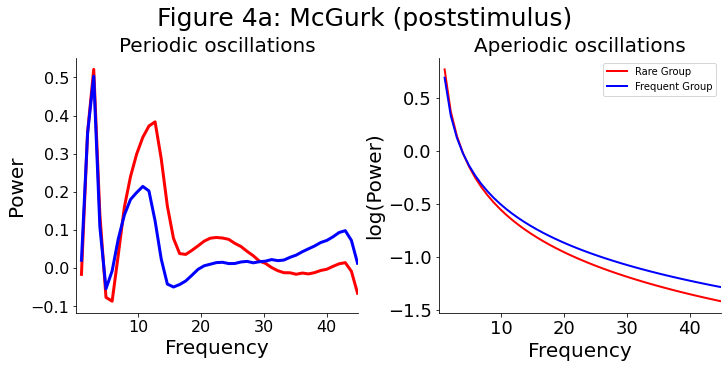

In [11]:
# Ploting Figure 4(a)
fig, ax = plt.subplots(1,2, figsize=[10, 5], sharex=True, constrained_layout = True)
# Set up labels and colors for plotting
labels = ['Rare Group', 'Frequent Group']

plot_spectrum(freqs_mcg_rare, pd_rare_mcg, color='r', log_powers=False, linewidth=3, ax=ax[0])
plot_spectrum(freqs_mcg_freq, pd_freq_mcg, color='b', log_powers=False, linewidth=3, ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(False)
ax[0].set_title('Periodic oscillations',fontsize=20);


# Code to plot Figure 4(b)
ax[1].plot(freqs_mcg_rare, ap_rare_mcg, label='Rare Group', color='red', linewidth=2)
ax[1].plot(freqs_mcg_freq, ap_freq_mcg, label='Frequent Group', color='blue', linewidth=2)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Aperiodic oscillations',fontsize=20)

plt.xlim(freq_range);
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('log(Power)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
if ttype == 1:
    fig.suptitle('Figure 4a: McGurk (prestimulus)', fontsize=25)
if ttype == 2:
    fig.suptitle('Figure 4a: McGurk (poststimulus)', fontsize=25)

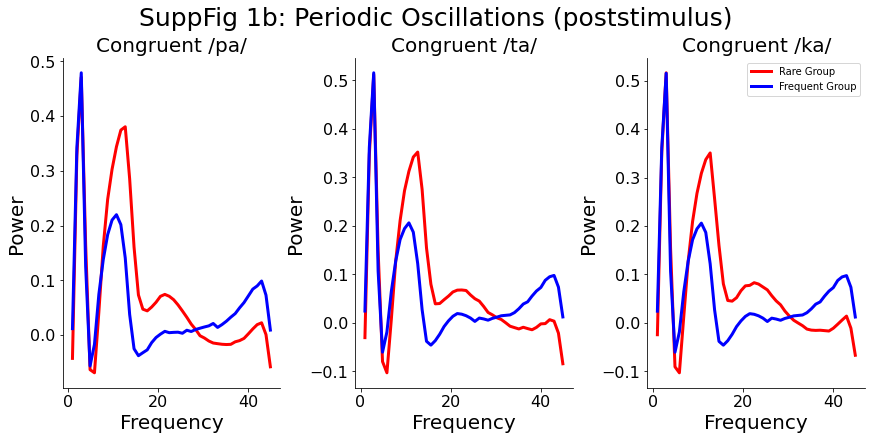

In [14]:
# Code to plot supplementary figure 1
fig, ax = plt.subplots(1,3, figsize=[12, 6], sharex=True, constrained_layout = True)
# Set up labels and colors for plotting
labels = ['Rare Group', 'Frequent Group']

plot_spectrum(freqs_cong_pa_rare, pd_rare_cong_pa, color='r', log_powers=False, linewidth=3, ax=ax[0])
plot_spectrum(freqs_cong_pa_freq, pd_freq_cong_pa, color='b', log_powers=False, linewidth=3, ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(False)
ax[0].set_title('Congruent /pa/',fontsize=20);

plot_spectrum(freqs_cong_ta_rare, pd_rare_cong_ta, color='r', log_powers=False, linewidth=3, ax=ax[1])
plot_spectrum(freqs_cong_ta_freq, pd_freq_cong_ta, color='b', log_powers=False, linewidth=3, ax=ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(False)
ax[1].set_title('Congruent /ta/',fontsize=20);

plot_spectrum(freqs_cong_ka_rare, pd_rare_cong_ka, color='r', log_powers=False, linewidth=3, ax=ax[2], label=labels[0])
plot_spectrum(freqs_cong_ka_freq, pd_freq_cong_ka, color='b', log_powers=False, linewidth=3, ax=ax[2], label=labels[1])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].grid(False)
ax[2].set_title('Congruent /ka/',fontsize=20);

plt.legend()
if ttype == 1:
    fig.suptitle('SuppFig 1a: Periodic Oscillations (prestimulus)', fontsize=25)
if ttype == 2:
    fig.suptitle('SuppFig 1b: Periodic Oscillations (poststimulus)', fontsize=25)

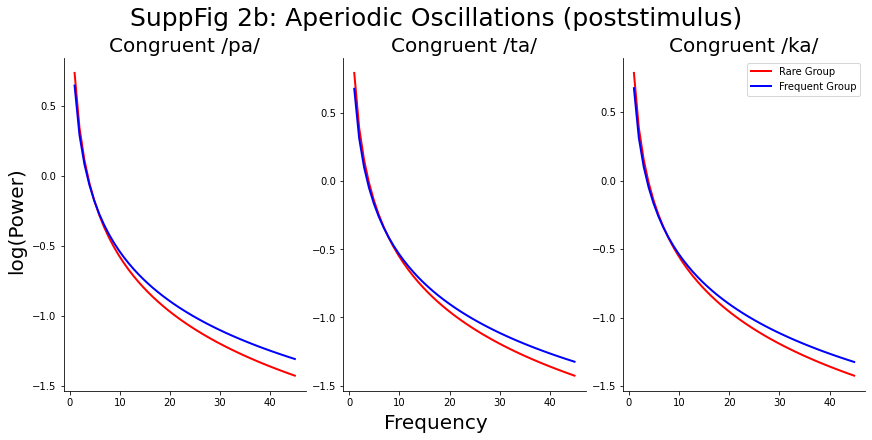

In [27]:
# Code to plot supplementary figure 2(a) / 
fig, ax = plt.subplots(1,3, figsize=[12, 6], constrained_layout=True)
# Set up labels and colors for plotting
labels = ['Rare Group', 'Frequent Group']

ax[0].plot(freqs_cong_pa_rare, ap_rare_cong_pa, color='red', linewidth=2)
ax[0].plot(freqs_cong_pa_freq, ap_freq_cong_pa, color='blue', linewidth=2)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title('Congruent /pa/',fontsize=20);

ax[1].plot(freqs_cong_ta_rare, ap_rare_cong_ta, color='red', linewidth=2)
ax[1].plot(freqs_cong_ta_freq, ap_freq_cong_ta, color='blue', linewidth=2)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Congruent /ta/',fontsize=20);

ax[2].plot(freqs_cong_ka_rare, ap_rare_cong_ka, color='red', linewidth=2, label=labels[0])
ax[2].plot(freqs_cong_ka_freq, ap_freq_cong_ka, color='blue', linewidth=2, label=labels[1])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_title('Congruent /ka/',fontsize=20);

plt.legend()
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
fig.supxlabel('Frequency',fontsize=20)
fig.supylabel('log(Power)',fontsize=20) 
if ttype == 1:
    fig.suptitle('SuppFig 2a: Aperiodic Oscillations (prestimulus)', fontsize=25)
if ttype == 2:
    fig.suptitle('SuppFig 2b: Aperiodic Oscillations (poststimulus)', fontsize=25)

In [ ]:
# Periodic oscillations channel-wise
rare_mcg_ch = fooof_topoplot(freqs_mcg_rare, psds_mcg_rare_ch, freq_range, ttype)
freq_mcg_ch = fooof_topoplot(freqs_mcg_freq, psds_mcg_freq_ch, freq_range, ttype)